# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
import sklearn.cluster
import seaborn as sns
import pandas as pd
import sparse
import cv2
import natsort

import torch
from kymatio.torch import Scattering2D

import gc
from tqdm.notebook import tqdm
import copy
import time
import random
import functools
import multiprocessing as mp


In [3]:
params = {
    'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
    'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
    'pathSuffixToStat': 'plane1/stat.npy',
    'pathSuffixToOps': 'plane1/ops.npy',
    'pref_use_NN_distances': True,
    'use_GPU': True,
    'pref_blurROIs': True,
    'params_blur': {
        'kernel_size': 7, # Edge length of kernel image. Make odd number.
        'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
    },
    'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
    'params_dIOU': {
        'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
        'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
    }
}

In [9]:
from psrecord.main import monitor

<IPython.core.display.Javascript object>


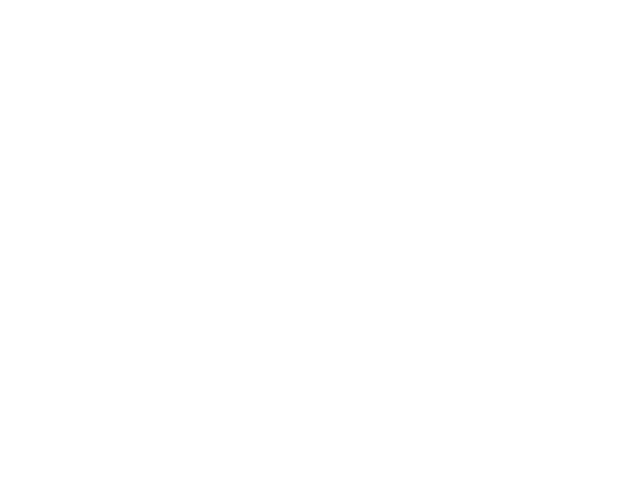

<IPython.core.display.Javascript object>


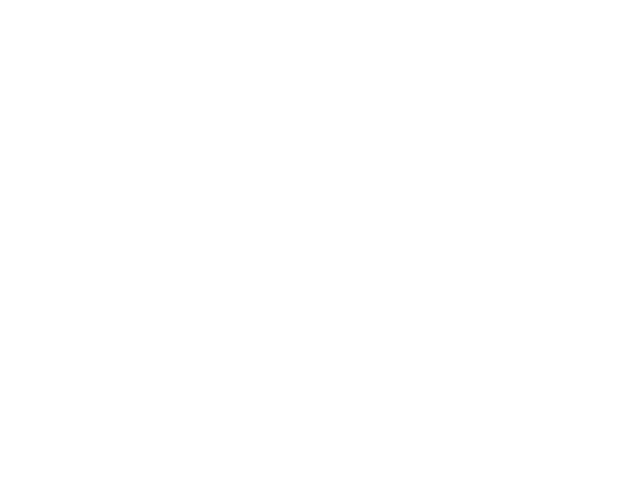

In [21]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()

In [24]:
import psutil

In [45]:
psutil.cpu_percent()

3.2

In [59]:
psutil.cpu_percent()

2.4

In [62]:
import time

In [71]:
cpu, mem = [], []
for _ in range(9999999999999999999):
    mem.append(psutil.virtual_memory().percent)
    cpu.append(psutil.cpu_percent())
    time.sleep(0.05)

KeyboardInterrupt: 

In [79]:
import numpy as np
(np.array(mem).max() - np.array(mem).min()) * 251/100

106.17300000000002

In [80]:
import numpy as np
20 * 251/100

50.2

In [81]:
np.array(cpu).mean()

13.589352748529775

<IPython.core.display.Javascript object>


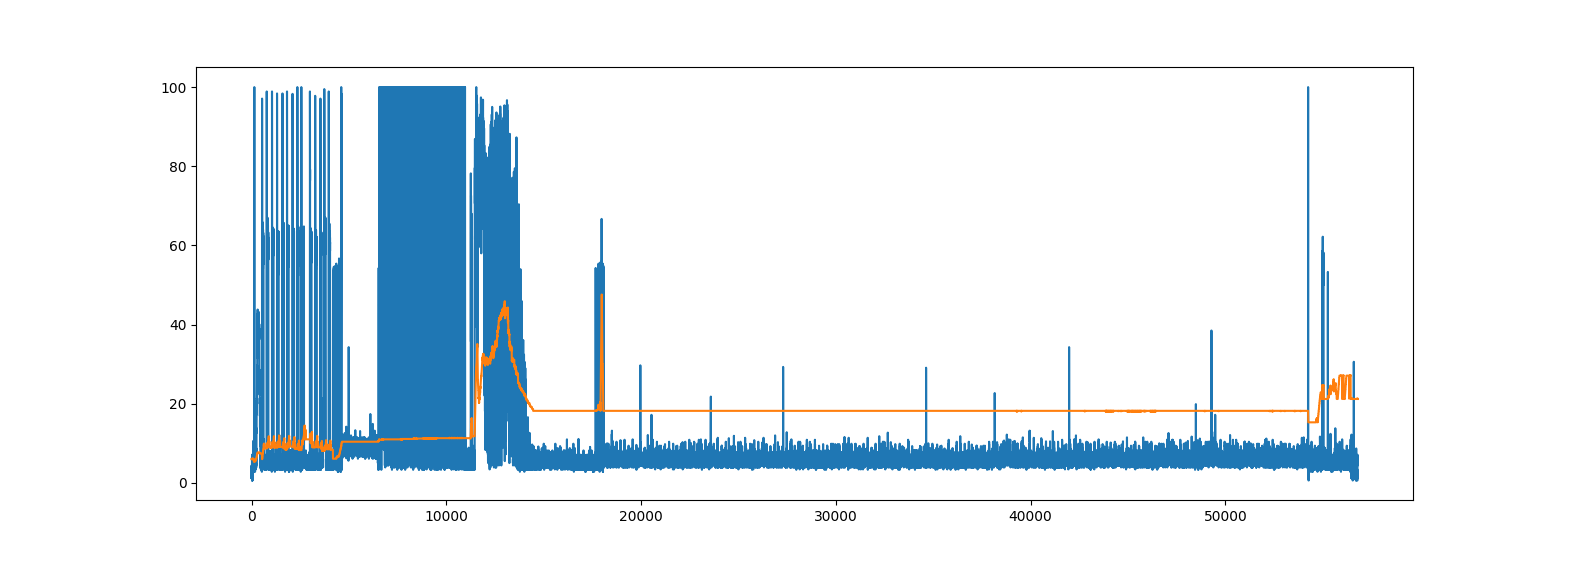

In [72]:
plt.figure()
plt.plot(cpu)
plt.plot(mem)

<IPython.core.display.Javascript object>


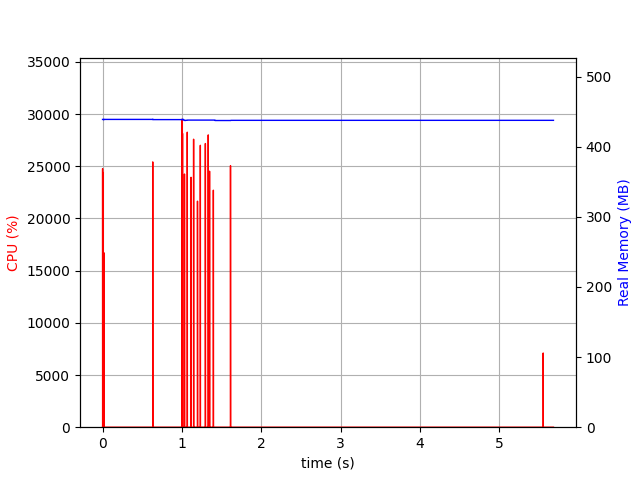

AttributeError: 'bool' object has no attribute 'write'

In [23]:
monitor(3531, plot=True)

In [ ]:
psrecord.main.

In [4]:
dir_github = Path(params['dir_github']).resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import path_helpers, torch_helpers, featurization, indexing, misc, torch_helpers, plotting_helpers, classification, math_functions, parallel_helpers, clustering, image_processing, pickle_helpers, container_helpers

In [5]:
device = torch_helpers.set_device(use_GPU=params['use_GPU'])

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


In [9]:
%load_ext autoreload
%autoreload 2
from registration_rClust import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, cluster_assignment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%matplotlib notebook

# Import paths

In [11]:
def print_list(l):
    for item in l:
        print(item)

In [12]:
dir_allOuterFolders = Path(params['dir_allOuterFolders']).resolve()

folders_allSessions = natsort.natsorted(path_helpers.get_dir_contents(dir_allOuterFolders)[0])

folders_toUse = folders_allSessions
# folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


# dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

pathSuffixToStat = params['pathSuffixToStat']
pathSuffixToOps = params['pathSuffixToOps']

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]

print(folders_allSessions)
print(folders_toUse)
print_list(dir_allS2pFolders)
print_list(paths_allStat)

['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D1
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D2
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D3
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D4
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D5
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D6
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D7
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Vale

# Import data

In [13]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    verbose=True,
)

In [14]:
data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[36, 36],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Imported 14 stat files into class as self.statFiles. Total number of ROIs: 37061. Number of ROI from each file: [2451, 2798, 2656, 2865, 2349, 2926, 2527, 2055, 4600, 2735, 2740, 1915, 2286, 2158]


100%|███████████████████████████████████████████| 14/14 [00:01<00:00, 10.76it/s]


Converted 14 spatial footprint files into small centered images in self.ROI_images.
Imported 14 FOV images into class as self.FOV_images
Imported 14 sessions of spatial footprints into sparse arrays.


In [15]:
# visualization.display_toggle_image_stack(data.FOV_images)

# Alignment

In [16]:
aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    templateFOV=data.FOV_images[0],
    FOVs=data.FOV_images,
    ROIs=data.spatialFootprints,
    return_sparse=True,
    normalize=True,
);

100%|███████████████████████████████████████████| 14/14 [03:03<00:00, 13.10s/it]


In [60]:
# visualization.display_toggle_image_stack(aligner.FOVs_aligned)
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

## Blur ROIs (optional)

In [18]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2.0,
    device='cpu',
    plot_kernel=False
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned,
    batch_size=2000,
);

In [19]:
# visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

## Neural network embedding distances

In [20]:
data.ROI_images[0].shape

(2451, 36, 36)

In [21]:
hash_dict_true = {
    'params': ('params.json', '877e17df8fa511a03bc99cd507a54403'),
    'model': ('model.py', '6ef5c29793ae16a64e43e8cab33d9ff4'),
    'state_dict': ('ConvNext_tiny__1_0_unfrozen__simCLR.pth', 'a5fae4c9ea95f2c78b4690222b2928a5'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    download_from_gDrive='check_local_first',
    gDriveID='1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8',
    hash_dict_networkFiles=hash_dict_true,
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    goal_size=250,
    ptile_norm=90,
    scale_norm=0.6,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
)

roinet.generate_latents();

Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|███████████████████████████████████████████| 14/14 [00:04<00:00,  3.13it/s]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


  0%|                                                  | 0/4633 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network


In [22]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [23]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 8}, 
    image_shape=(36,36), 
    device='cuda:0'
)

swt.transform(ROI_images=np.concatenate(data.ROI_images, axis=0));

## Compute similarities

In [24]:
sim = similarity_graph.ROI_graph(
    device='cpu',
    n_workers=-1,
    spatialFootprint_maskPower=0.8,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=50,
    block_width=50,
    overlapping_width_Multiplier=0.1,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    n_neighbors_nearestNeighbors_spatialFootprints='full',
    locality=1,
    verbose=True,
)

<IPython.core.display.Javascript object>


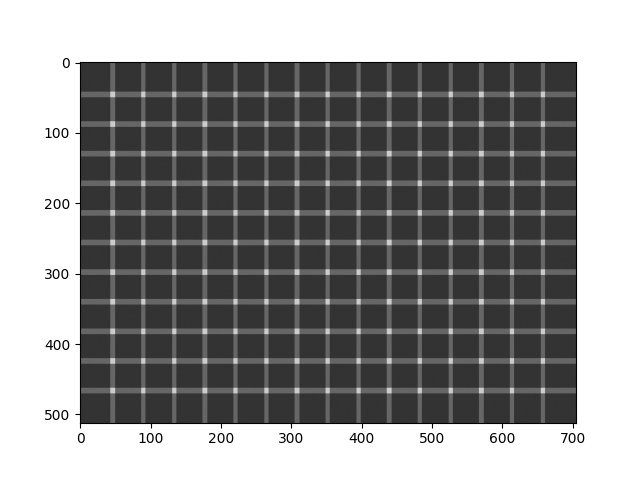

In [26]:
sim.visualize_blocks()

In [40]:
sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    linkage_methods=['single', 'complete', 'ward', 'average'],
    linkage_distances=math_functions.bounded_logspace(0.05, 2, 50),
    min_cluster_size=2,
    max_cluster_size=None,
    batch_size_hashing=300,
);

sim.compute_cluster_similarity_graph(
        cluster_similarity_reduction_intra='mean',
        cluster_similarity_reduction_inter='max',
        cluster_silhouette_reduction_intra='mean',
        cluster_silhouette_reduction_inter='max',
        n_workers=100,
);

sim.compute_cluster_scores(
    power_clusterSize=2, 
    power_clusterSilhouette=1.5
);

Computing pairwise similarity between ROIs...


100%|█████████████████████████████████████████| 192/192 [03:47<00:00,  1.19s/it]


Removing duplicate clusters...


<IPython.core.display.Javascript object>


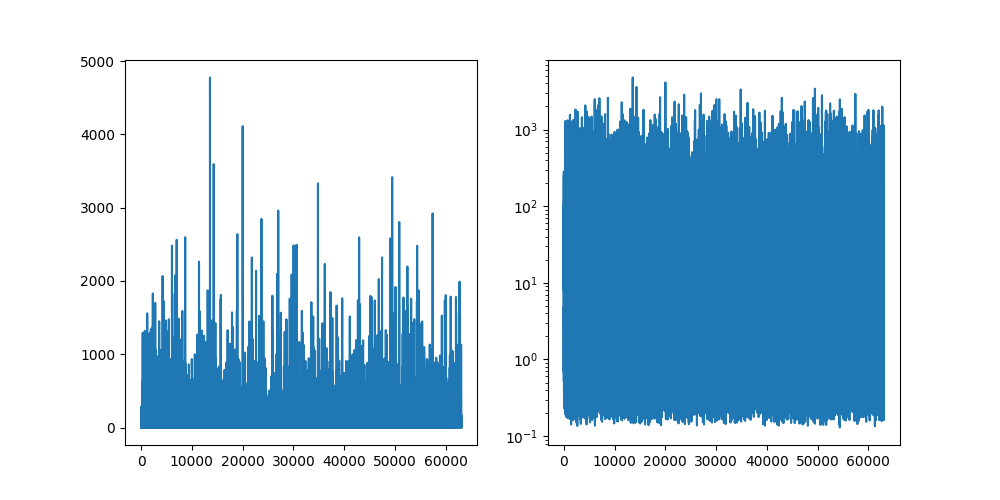

In [42]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(sim.scores.cpu())
# plt.ylim([0,1.1])
axs[1].plot(sim.scores.cpu())
axs[1].set_yscale('log')

<IPython.core.display.Javascript object>


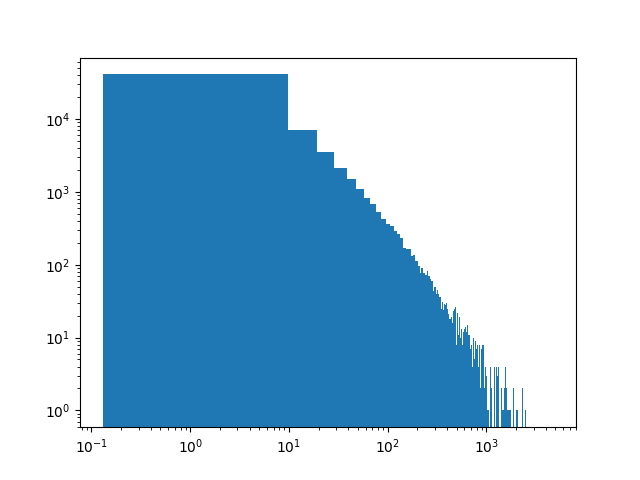

In [44]:
plt.figure()
plt.hist(sim.scores.cpu(), 500)
plt.yscale('log')
plt.xscale('log')

<IPython.core.display.Javascript object>


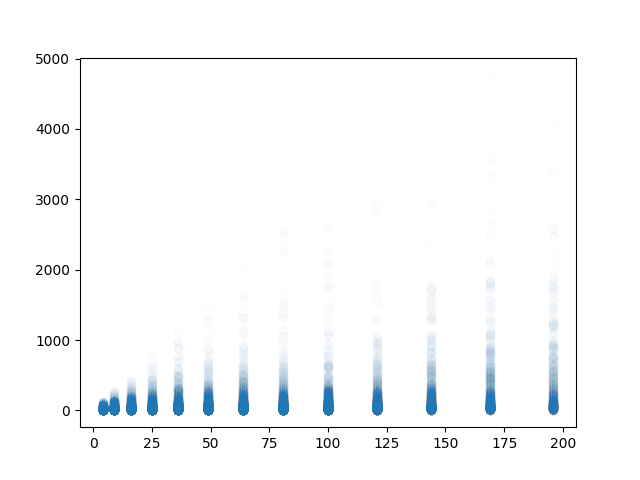

In [47]:
plt.figure()
plt.scatter((np.array(sim.cluster_bool.sum(1)).squeeze()), sim.scores, alpha=0.01)

In [51]:
clusterAssigner = cluster_assignment.Cluster_Assigner(
    c=sim.c_sim,
    h=sim.cluster_bool.T,
    w=sim.scores,
    device='cuda:0',
    m_init=(torch.ones(sim.c_sim.shape[0])*-5 + torch.rand(sim.c_sim.shape[0])*1).type(torch.float32),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=1e-1, betas=(0.9, 0.900)),
    scheduler_partial=functools.partial(torch.optim.lr_scheduler.CyclicLR, base_lr=1e-3, max_lr=3e0, step_size_up=250, cycle_momentum=False, verbose=False),
    dmCEL_temp=1,
    dmCEL_sigSlope=2,
    dmCEL_sigCenter=0.5,
    dmCEL_penalty=1e0,
    sampleWeight_softplusKwargs={'beta': 500, 'threshold': 50},
    sampleWeight_penalty=1e2,
    fracWeighted_goalFrac=1.0,
    fracWeighted_sigSlope=2,
    fracWeighted_sigCenter=0.5,
    fracWeight_penalty=1e2,
    maskL1_penalty=2e-5,
    tol_convergence=1e-9,
    window_convergence=50,
    freqCheck_convergence=50,
    verbose=True,
)

In [52]:
clusterAssigner.fit(
    min_iter=1e3,
    max_iter=2e3,
    verbose=True, 
    verbose_interval=10
)

iter: 0:  loss_total: 53.5611  lr: 0.01300   loss_cs: 0.1167  loss_fracWeighted: 53.4444  loss_sampleWeight: 0.0000  loss_maskL1: 0.0001  diff_loss: nan  loss_smooth: nan
iter: 10:  loss_total: 53.4699  lr: 0.13296   loss_cs: 0.0260  loss_fracWeighted: 53.4438  loss_sampleWeight: 0.0000  loss_maskL1: 0.0001  diff_loss: nan  loss_smooth: nan
iter: 20:  loss_total: 53.4325  lr: 0.25292   loss_cs: 0.0022  loss_fracWeighted: 53.4285  loss_sampleWeight: 0.0000  loss_maskL1: 0.0018  diff_loss: nan  loss_smooth: nan
iter: 30:  loss_total: 53.9378  lr: 0.37288   loss_cs: 0.0126  loss_fracWeighted: 52.8756  loss_sampleWeight: 1.0157  loss_maskL1: 0.0339  diff_loss: nan  loss_smooth: nan
iter: 40:  loss_total: 52.5294  lr: 0.49284   loss_cs: 0.0209  loss_fracWeighted: 52.4148  loss_sampleWeight: 0.0661  loss_maskL1: 0.0275  diff_loss: nan  loss_smooth: nan
iter: 50:  loss_total: 52.1488  lr: 0.61280   loss_cs: 0.0199  loss_fracWeighted: 52.0573  loss_sampleWeight: 0.0445  loss_maskL1: 0.0271  di

iter: 480:  loss_total: 51.3704  lr: 0.22892   loss_cs: 0.0102  loss_fracWeighted: 51.3080  loss_sampleWeight: 0.0018  loss_maskL1: 0.0503  diff_loss: nan  loss_smooth: nan
iter: 490:  loss_total: 51.3703  lr: 0.10896   loss_cs: 0.0102  loss_fracWeighted: 51.3080  loss_sampleWeight: 0.0018  loss_maskL1: 0.0503  diff_loss: nan  loss_smooth: nan
iter: 500:  loss_total: 51.3704  lr: 0.01300   loss_cs: 0.0102  loss_fracWeighted: 51.3080  loss_sampleWeight: 0.0018  loss_maskL1: 0.0503  diff_loss: nan  loss_smooth: nan


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


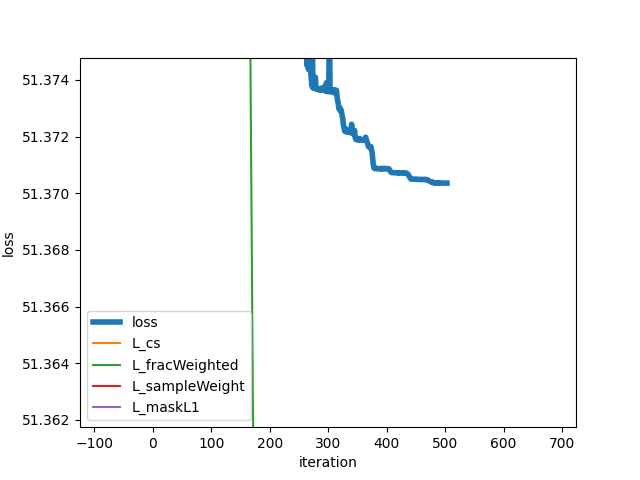

In [53]:
clusterAssigner.plot_loss()

In [ ]:
gc.collect()

torch.cuda.empty_cache()

gc.collect()

torch.cuda.empty_cache()

<IPython.core.display.Javascript object>


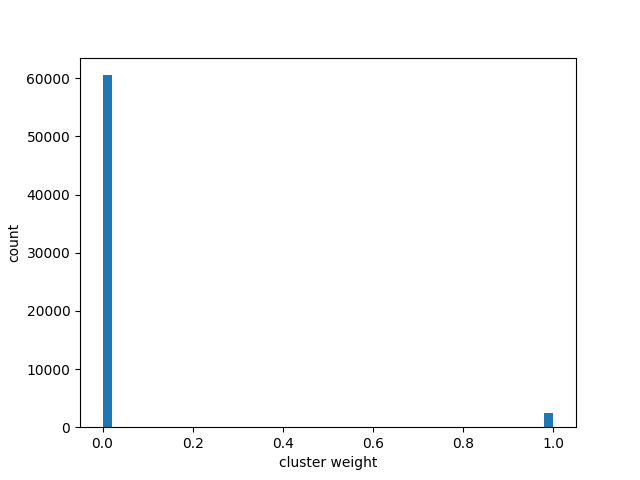

<IPython.core.display.Javascript object>


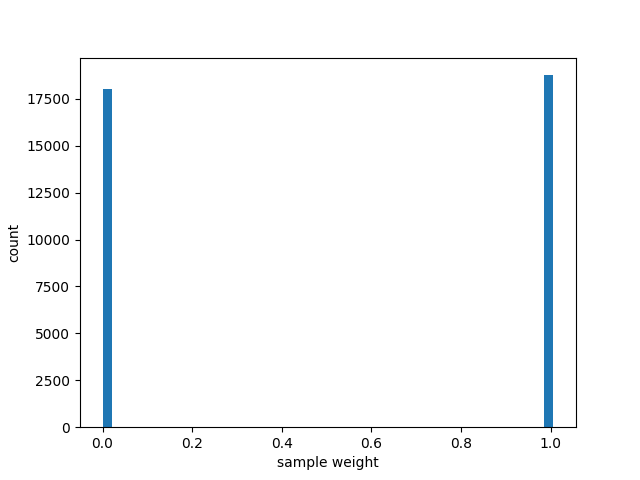

[37061, 2527]


<IPython.core.display.Javascript object>


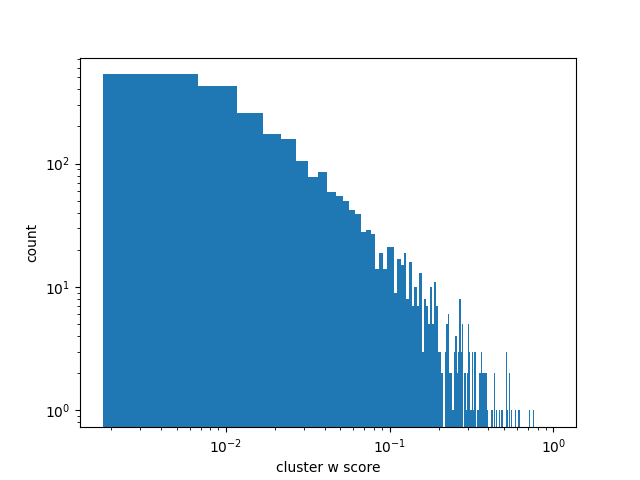

In [54]:
clusterAssigner.plot_clusterWeights()

clusterAssigner.plot_sampleWeights()

clusterAssigner.plot_clusterScores(bins=200)
plt.xscale('log')
plt.yscale('log')

[37061, 2489]


<IPython.core.display.Javascript object>


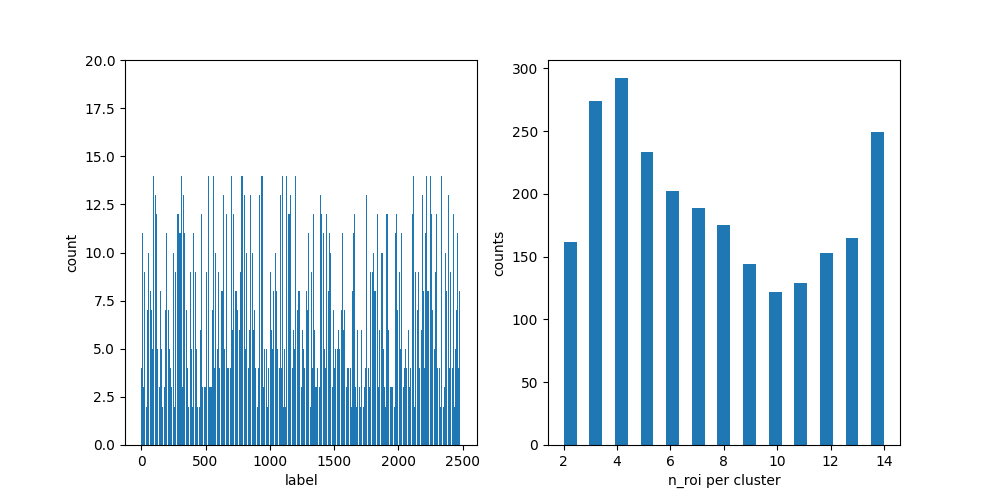

Number of clusters: 2489


In [56]:
m_threshold=0.9

preds, confidence, scores_samples, m_bool = clusterAssigner.predict(m_threshold=m_threshold)

fig, axs = clusterAssigner.plot_labelCounts()
axs[0].set_ylim([0,20])

print(f'Number of clusters: {m_bool.sum()}')

<IPython.core.display.Javascript object>


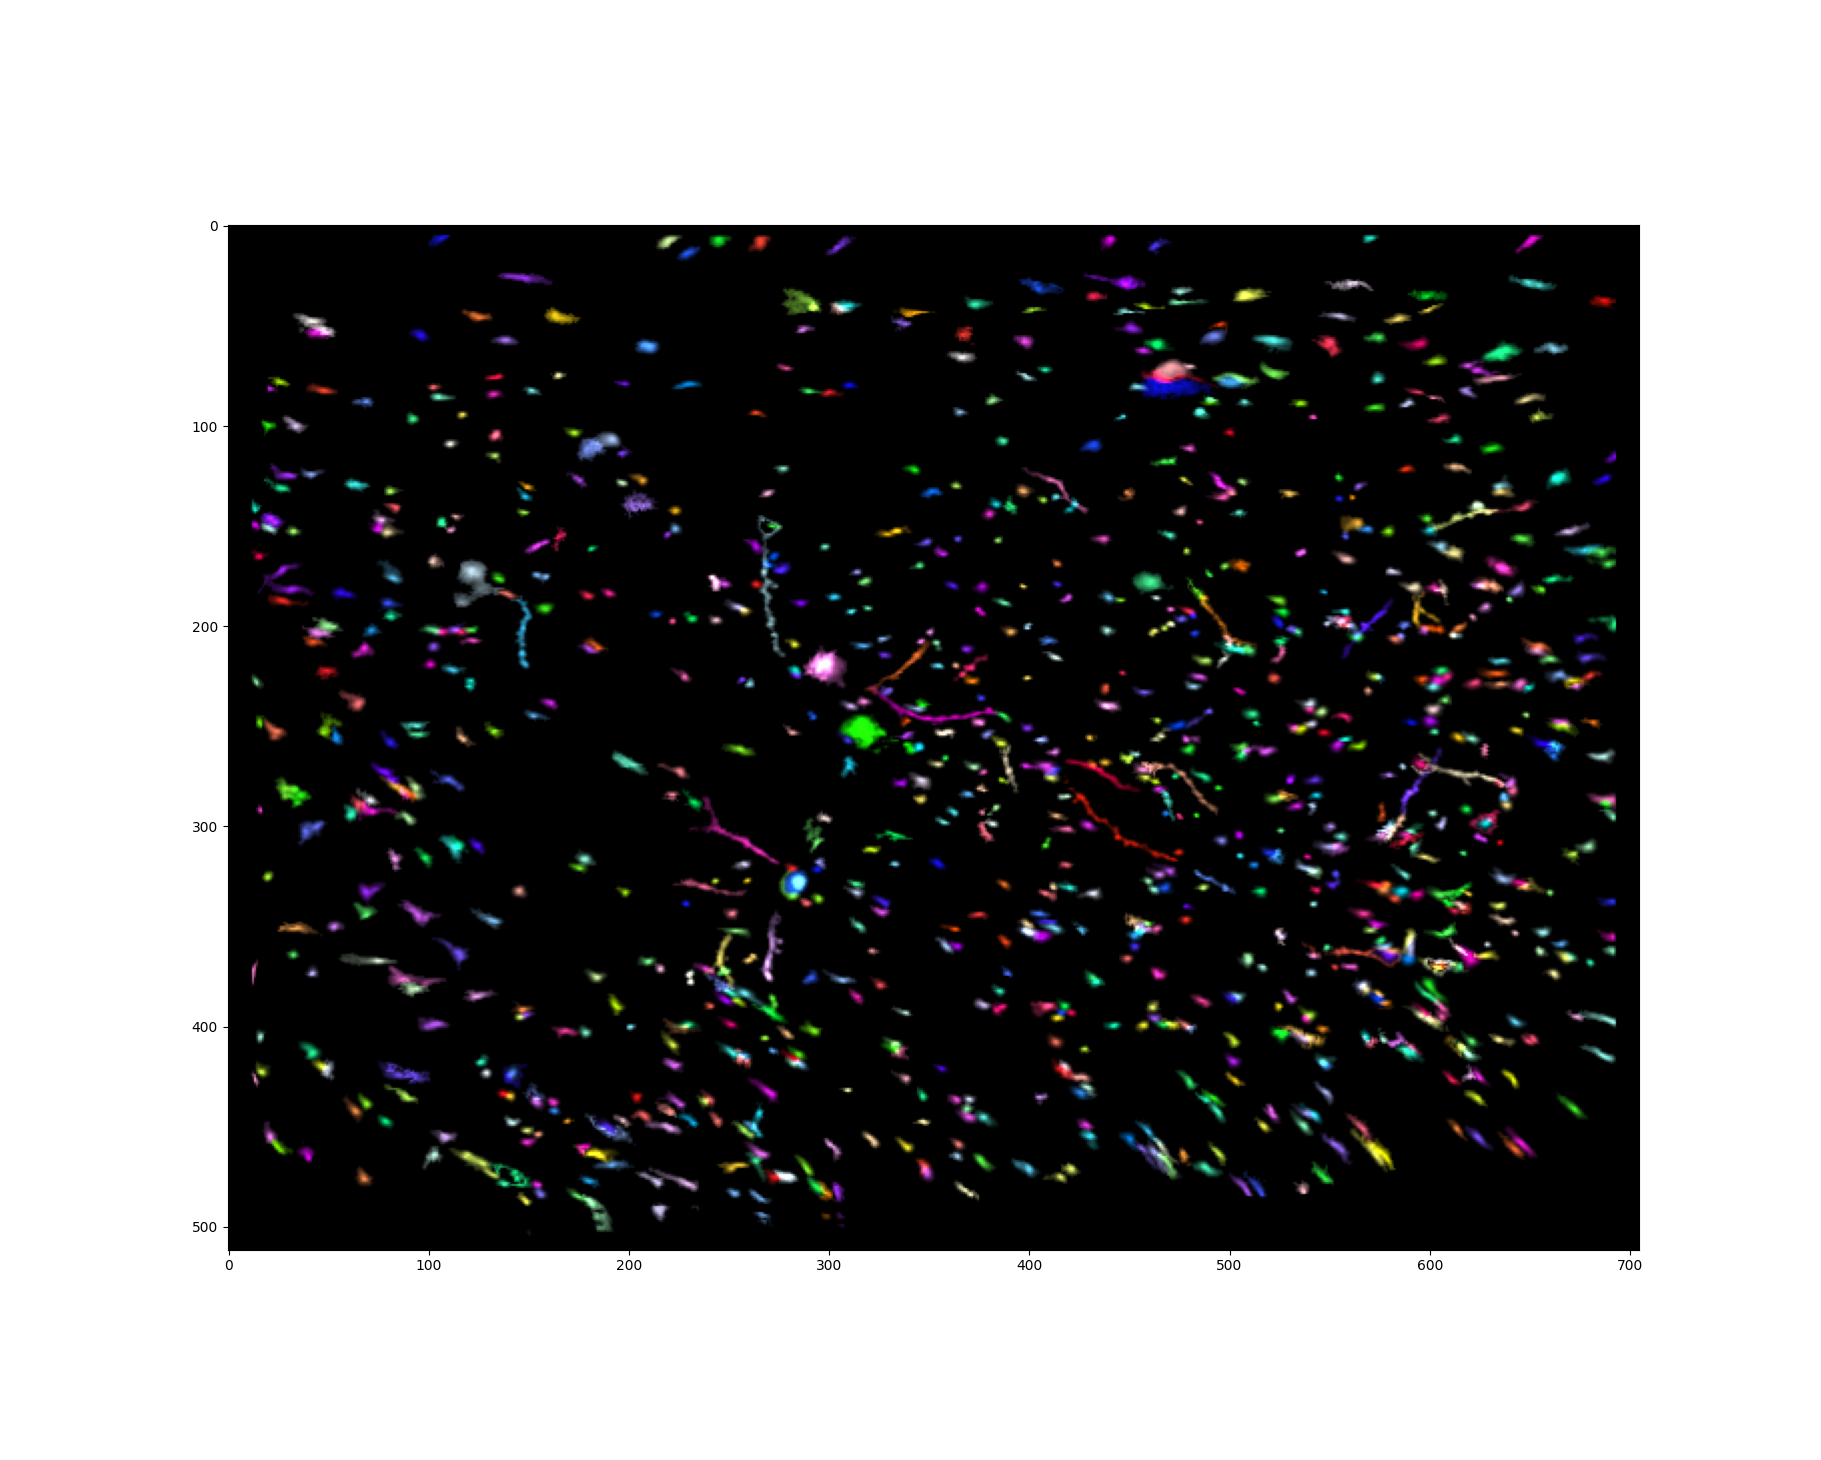

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [57]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=clusterAssigner.preds,
    confidence=clusterAssigner.confidence,
    threshold_confidence = 0.5
)

visualization.display_toggle_image_stack(FOV_clusters)